In [1]:
%load_ext hamilton.plugins.jupyter_magic

## Model Training Dataflow

### 1. Define

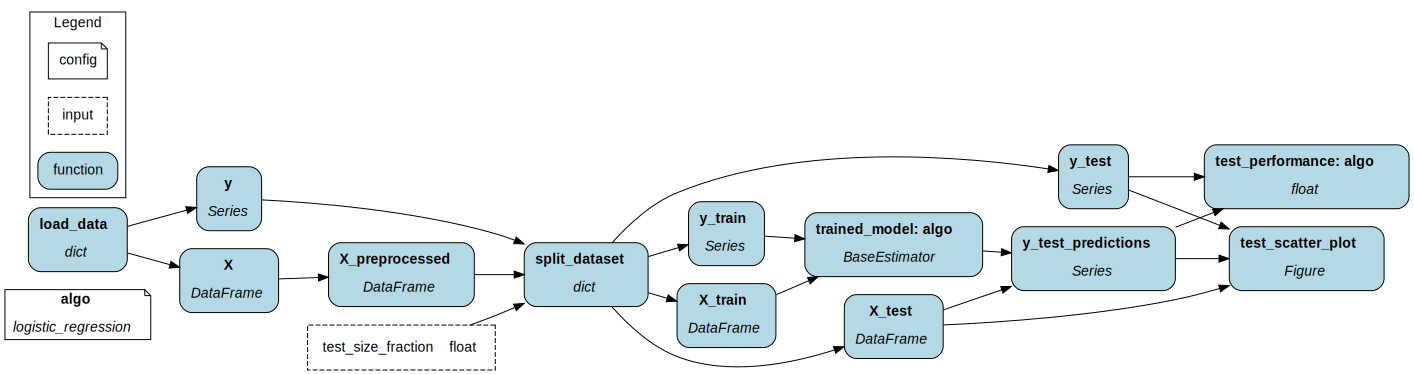

In [2]:
%%cell_to_module model_training --display --config algo=logistic_regression
from typing import Dict, Union

import pandas as pd
import matplotlib.figure
import matplotlib.pyplot as plt
import numpy as np
from sklearn.base import BaseEstimator
from sklearn.datasets import fetch_openml
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, mean_absolute_error
from hamilton.function_modifiers import extract_fields, tag, config


@extract_fields(dict(X=pd.DataFrame, y=pd.Series))
def load_data() -> dict:
    X, y = fetch_openml("titanic", version=1, as_frame=True, return_X_y=True)
    return dict(X=X, y=y)


def X_preprocessed(X: pd.DataFrame) -> pd.DataFrame:
    column_selection = ["fare", "age"]
    X = X[column_selection]
    X = X.fillna(0)
    return X 


@extract_fields(dict(
    X_train=pd.DataFrame,
    y_train=pd.Series,
    X_test=pd.DataFrame,
    y_test=pd.Series,
))
def split_dataset(
    X_preprocessed: pd.DataFrame,
    y: pd.Series,
    test_size_fraction: float = 0.3
) -> dict:
    """Load the titanic dataset and partition it in X_train, y_train, X_test, y_test"""
    X_train, X_test, y_train, y_test = train_test_split(
        X_preprocessed, y, test_size=test_size_fraction,
    )
    return dict(
        X_train=X_train,
        y_train=y_train,
        X_test=X_test,
        y_test=y_test,
    )

@tag(team="forecast")
@config.when(algo="logistic_regression")
def trained_model__loistic(X_train: pd.DataFrame, y_train: pd.Series, hparams: dict) -> BaseEstimator:
    """Fit a binary classifier on the training data"""
    model = LogisticRegression()
    model.fit(X_train, y_train)
    return model


@tag(team="forecast")
@config.when(algo="linear_regression")
def trained_model__linear(X_train: pd.DataFrame, y_train: pd.Series) -> BaseEstimator:
    """Fit a binary classifier on the training data"""
    model = LinearRegression()
    model.fit(X_train, y_train)
    return model

def y_test_predictions(trained_model: BaseEstimator, X_test: pd.DataFrame) -> pd.Series:
    return trained_model.predict(X_test)

@config.when(algo="logistic_regression")
def test_performance__logistic(y_test: pd.Series, y_test_predictions: pd.Series) -> float:
    return balanced_accuracy_score(y_test, y_test_predictions)

@config.when(algo="linear_regression")
def test_performance__linear(y_test: pd.Series, y_test_predictions: pd.Series) -> float:
    return mean_absolute_error(y_test, y_test_predictions)

def test_scatter_plot(
    X_test: pd.DataFrame,
    y_test: pd.Series,
    y_test_predictions: pd.Series,
) -> matplotlib.figure.Figure:
    correctly_predicted = y_test == y_test_predictions
    feature_1 = X_test.iloc[:, 0]
    feature_2 = X_test.iloc[:, 1]

    fig = plt.figure()
    plt.scatter(feature_1, feature_2, c=correctly_predicted)
    return fig

### 2. Assemble

In [ ]:
from hamilton import driver
from hamilton.io.materialization import to

dr = (
    driver.Builder()
    .with_modules(model_training)
    .with_config(dict(algo="logistic_regression"))
    .with_materializers(
        to.mlflow(
            id="trained_model__mlflow",
            dependencies=["trained_model"],
            mode="runs",
            register=True,
            model_name="my_classifier",
        ),
    )
    .build()
)
dr

### 3. Execute

In [ ]:
final_vars = ["trained_model__mlflow", "y_test_predictions", "test_performance"]
results = dr.execute(final_vars)
dr.visualize_execution(final_vars)

In [ ]:
# balanced accuracy on test set
print(results["test_performance"])
print()
# metadata of stored model
results["trained_model__mlflow"]

## Model Inference Dataflow

### 1. Define

In [ ]:
%%cell_to_module model_inference --display
from typing import Dict, Union

import pandas as pd
from sklearn.base import BaseEstimator
from sklearn.datasets import fetch_openml
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score
from hamilton.function_modifiers import extract_fields

# import the preprocessing function from the module above
from model_training import X_preprocessed

def preprocessed_inputs(user_input: dict) -> pd.DataFrame:
    df = pd.DataFrame(user_input, index=[0])
    df = X_preprocessed(df)
    return df

def prediction(preprocessed_inputs: pd.DataFrame, model: BaseEstimator) -> int:
    return model.predict(preprocessed_inputs)

### 2. Assemble

In [ ]:
from hamilton import driver
from hamilton.io.materialization import from_

dr = (
    driver.Builder()
    .with_modules(model_inference)
    .with_materializers(
        from_.mlflow(
            target="model",
            mode="registry",
            model_name="my_classifier",
        ),
    )
    .build()
)
dr

### 3. Execute

In [ ]:
inputs = dict(user_input={"fare": 10.72, "age": 48})

final_vars = ["prediction", "load_data.model"]
results = dr.execute(final_vars, inputs=inputs)
dr.visualize_execution(final_vars, inputs=inputs)

In [ ]:
print(results["prediction"])
results["load_data.model"]

## MLFlowTracker

In [3]:
import importlib
from hamilton import driver
import hamilton.plugins.h_mlflow
from hamilton.io.materialization import to
from hamilton.plugins.h_mlflow import MLFlowTracker
importlib.reload(hamilton.plugins.h_mlflow)

dr = (
    driver.Builder()
    .with_modules(model_training)
    .with_config(dict(algo="logistic_regression"))
    .with_adapters(
        hamilton.plugins.h_mlflow.MLFlowTracker()
    )
    .with_materializers(
        to.mlflow(
            id="trained_model__mlflow",
            dependencies=["trained_model"],
            mode="runs",
            register=True,
            model_name="my_loom_video",
        ),
    )
    .build()
)

/home/tjean/projects/dagworks/hamilton/venv/lib/python3.11/site-packages/_distutils_hack/__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/home/tjean/projects/dagworks/hamilton/venv/lib/python3.11/site-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
Registered model 'my_loom_video' already exists. Creating a new version of this model...
Created version '2' of model 'my_loom_video'.


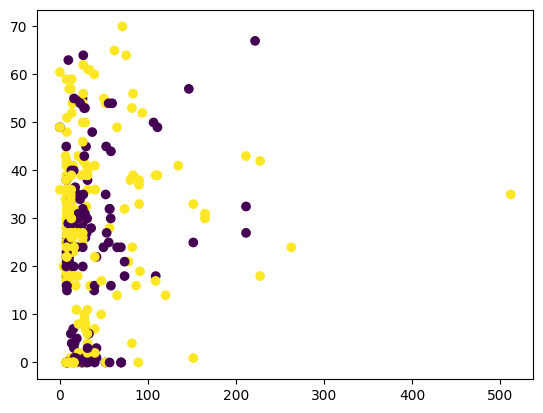

In [5]:
inputs = dict(test_size_fraction=0.3)
results = dr.execute(
    ["trained_model__mlflow", "test_performance", "test_scatter_plot"],
    inputs=inputs
)